In [ ]:
!pip install pandas numpy matplotlib seaborn tqdm sentence-transformers chromadb pyarrow

# Part 2: AI Module - Embeddings & Vector Search

**AI Models Used:**
1. **Segment 1**: Text Embeddings (Transformer Model)
2. **Segment 2**: Vector Search (Similarity/Clustering)

**Flow**: Load Data → Create Embeddings → Build Vector DB → Test Search

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## Step 1: Load Cleaned Data

Load the parquet file from Part 1 (fast reload!)

In [2]:
# Load data from Part 1
data_path = Path('../data/processed/papers.parquet')

if not data_path.exists():
    raise FileNotFoundError("Run Part 1 first to create papers.parquet!")

print("Loading data...")
start = time.time()
df = pd.read_parquet(data_path)
print(f"Loaded {len(df):,} papers in {time.time()-start:.2f} seconds\n")

df.head()

Loading data...
Loaded 19,523 papers in 0.52 seconds



,id,scopus_id,doi,title,abstract,year,citation_count,authors,affiliations,references,abstract_length,num_authors,num_references,summary,subject_areas
0,201800001,85060936020,10.23919/PIERS.2018.8597669,Flexible Printed Active Antenna for Digital Te...,This paper presents the development of a flexi...,2018,1,Pratumsiri T.;Janpugdee P.,,85006043726;85046336244;85060914424;85046368249,1199,2,4,None,"[Electrical and Electronic Engineering, Electr..."
1,201800002,85052201238,10.1016/j.ces.2018.08.042,Parametric study of hydrogen production via so...,Computational fluid dynamics was applied for s...,2018,21,Phuakpunk K.;Chalermsinsuwan B.;Putivisutisak ...,,,957,4,0,None,"[Chemistry (all), Chemical Engineering (all), ..."
2,201800003,85051498032,10.1016/j.apsusc.2018.08.059,Superhydrophobic coating from fluoroalkylsilan...,A superhydrophobic/superoleophilic mesh was su...,2018,37,Saengkaew J.;Le D.;Samart C.;Sawada H.;Nishida...,Hirosaki University;Chulalongkorn University;T...,,1082,8,0,None,"[Chemistry (all), Condensed Matter Physics, Ph..."
3,201800004,85050678366,10.1016/j.aca.2018.07.045,Electrochemical impedance-based DNA sensor usi...,A label-free electrochemical DNA sensor based ...,2018,68,Teengam P.;Siangproh W.;Tuantranont A.;Vilaiva...,Chulalongkorn University;Thailand National Ele...,,1668,6,0,None,"[Analytical Chemistry, Biochemistry, Environme..."
4,201800005,85059846549,10.17512/pjms.2018.18.2.24,Evaluation of outsourcing transportation contr...,This paper aims to develop an approach to iden...,2018,15,Setamanit S.-O.,,54349103890;0033235290;69649096182;85043470598...,884,1,20,None,"[Business and International Management, Strate..."


In [3]:
# Quick stats
print(f"Total papers: {len(df):,}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print(f"Average abstract length: {df['abstract_length'].mean():.0f} chars")

Total papers: 19,523
Year range: 2018 - 2023
Average abstract length: 1411 chars


---

# 🤖 AI MODEL SEGMENT 1: Text Embeddings (Transformer)

## What is it?
Convert text (title + abstract) into numerical vectors using a pre-trained transformer model.

## Why?
Enable **semantic search** - find papers by meaning, not just keywords.

## Model Details:
- **Name**: `sentence-transformers/all-MiniLM-L6-v2`
- **Type**: Transformer-based sentence embedding model
- **Output**: 384-dimensional dense vectors
- **Speed**: ~2-5 minutes for 18K papers
- **Why this model?**: Free, fast, good quality, runs locally

In [4]:

!pip install sentence-transformers

In [5]:
from sentence_transformers import SentenceTransformer

print("Loading sentence-transformers model...")
print("Model: all-MiniLM-L6-v2")
print("First time: downloads ~80MB\n")

model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"✓ Model loaded")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Max sequence length: {model.max_seq_length}")

Loading sentence-transformers model...
Model: all-MiniLM-L6-v2
First time: downloads ~80MB

✓ Model loaded
  Embedding dimension: 384
  Max sequence length: 256


### How Embeddings Work

**Example**:
```
Text: "Machine learning improves medical diagnosis"
       ↓ (Transformer model)
Vector: [0.234, -0.412, 0.881, ..., 0.567] (384 numbers)

Similar text: "AI helps doctors detect diseases"
       ↓
Vector: [0.251, -0.398, 0.865, ..., 0.543] (very similar numbers!)
```

Papers with similar meaning → Similar vectors → Found by search

In [6]:
# Test on one paper
sample_text = df.iloc[0]['title'] + " " + df.iloc[0]['abstract']
sample_embedding = model.encode(sample_text)

print(f"Sample paper:")
print(f"  Title: {df.iloc[0]['title'][:80]}...")
print(f"  Text length: {len(sample_text)} chars")
print(f"\nEmbedding:")
print(f"  Shape: {sample_embedding.shape}")
print(f"  First 10 values: {sample_embedding[:10]}")
print(f"  Range: [{sample_embedding.min():.3f}, {sample_embedding.max():.3f}]")

Sample paper:
  Title: Flexible Printed Active Antenna for Digital Television Reception...
  Text length: 1264 chars

Embedding:
  Shape: (384,)
  First 10 values: [-0.02114792  0.11214112 -0.07967681 -0.07978276 -0.00630727 -0.03095568
  0.04642126  0.11051878 -0.06546298 -0.01672824]
  Range: [-0.149, 0.138]


### Checkpoint: Check if embeddings already exist

In [7]:
embeddings_dir = Path('../data/embeddings')
embeddings_file = embeddings_dir / 'paper_embeddings.npy'

if embeddings_file.exists():
    print("Found existing embeddings!")
    embeddings = np.load(embeddings_file)
    print(f"Loaded embeddings: {embeddings.shape}")
    print("\nSkip to Segment 2 (Vector Search) or re-run below to recreate.")
else:
    print("No existing embeddings. Will create below.")

Found existing embeddings!
Loaded embeddings: (19523, 384)

Skip to Segment 2 (Vector Search) or re-run below to recreate.


### Create Embeddings for All Papers (2-5 minutes)

In [ ]:
# Combine title + abstract for each paper
texts = (df['title'] + " " + df['abstract']).tolist()

print(f"Creating embeddings for {len(texts):,} papers...")
print("This takes 2-5 minutes\n")

# Encode in batches (faster)
batch_size = 32
start = time.time()

embeddings = model.encode(
    texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)

elapsed = time.time() - start

print(f"\n✓ Created embeddings in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
print(f"  Shape: {embeddings.shape}")
print(f"  Size: {embeddings.nbytes / 1024 / 1024:.1f} MB")

Creating embeddings for 19,523 papers...
This takes 2-5 minutes



Batches:   0%|          | 0/611 [00:00<?, ?it/s]

### Save Embeddings

In [ ]:
# Create directory
embeddings_dir.mkdir(parents=True, exist_ok=True)

# Save as numpy array
np.save(embeddings_file, embeddings)

print(f"Saved to: {embeddings_file}")
print(f"File size: {embeddings_file.stat().st_size / 1024 / 1024:.1f} MB")

# Also save metadata
metadata = {
    'model_name': 'all-MiniLM-L6-v2',
    'embedding_dim': 384,
    'num_papers': len(embeddings),
    'created_at': time.strftime('%Y-%m-%d %H:%M:%S')
}

with open(embeddings_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n✓ Embeddings saved!")

Saved to: ..\data\embeddings\paper_embeddings.npy
File size: 28.6 MB

✓ Embeddings saved!


### Visualize Embeddings Distribution

Embedding Statistics:
  Mean: -0.0003
  Std: 0.0510
  Min: -0.2571
  Max: 0.2828


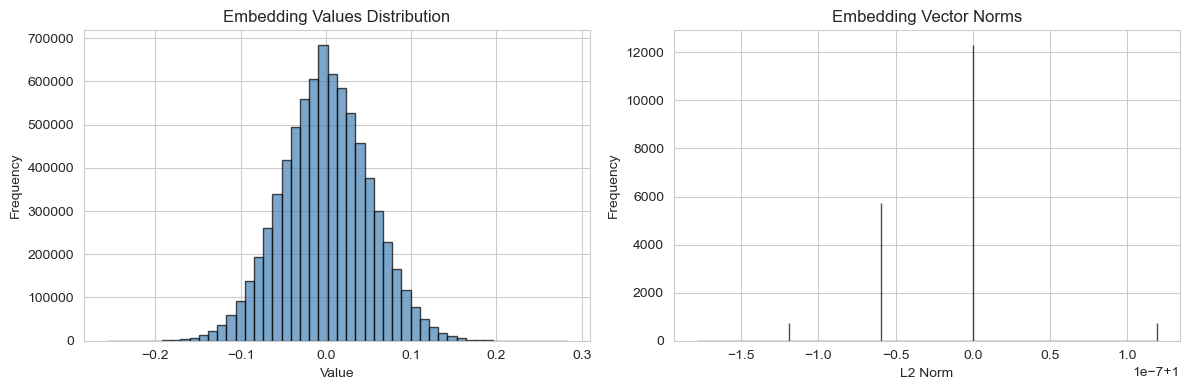

In [ ]:
# Check embedding statistics
print("Embedding Statistics:")
print(f"  Mean: {embeddings.mean():.4f}")
print(f"  Std: {embeddings.std():.4f}")
print(f"  Min: {embeddings.min():.4f}")
print(f"  Max: {embeddings.max():.4f}")

# Plot distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(embeddings.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Embedding Values Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
norms = np.linalg.norm(embeddings, axis=1)
plt.hist(norms, bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.title('Embedding Vector Norms')
plt.xlabel('L2 Norm')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

---

# 🤖 AI MODEL SEGMENT 2: Vector Search (Similarity/Clustering)

## What is it?
Build a vector database that can quickly find similar papers using cosine similarity.

## Why?
Enable **fast semantic search** - find top 50 relevant papers in <0.1 seconds.

## Model Details:
- **Name**: ChromaDB with HNSW (Hierarchical Navigable Small World)
- **Type**: Vector similarity search / nearest neighbor
- **Algorithm**: HNSW graph-based indexing
- **Speed**: 0.03-0.1 seconds per query
- **Why this model?**: Free, fast for 20K papers, persistent storage

In [ ]:

!pip install chromadb

In [ ]:
import chromadb
from chromadb.config import Settings

print("ChromaDB version:", chromadb.__version__)

ChromaDB version: 1.3.5


### How Vector Search Works

**Cosine Similarity**:
```
Query: "machine learning in healthcare"
       ↓ (encode)
Query vector: [0.82, 0.91, ...]

Compare with all papers:
  Paper A: [0.85, 0.92, ...] → Similarity = 0.95 (very similar!) ✓
  Paper B: [0.12, 0.21, ...] → Similarity = 0.15 (not similar) ✗

Return top 50 with highest similarity
```

**HNSW Algorithm**:
- Instead of checking all 20K papers (slow)
- Builds a multi-layer graph (like highways + local roads)
- Jumps to promising areas quickly
- Checks only ~100-200 papers
- Result: 100x faster!

### Create Vector Database

In [ ]:
# Setup ChromaDB (persistent)
db_path = Path('../data/vector_db')
db_path.mkdir(parents=True, exist_ok=True)

print(f"Creating ChromaDB at: {db_path}")

client = chromadb.PersistentClient(path=str(db_path))

# Check if collection exists
try:
    client.delete_collection("papers")
    print("Deleted existing collection")
except:
    pass

# Create new collection
collection = client.create_collection(
    name="papers",
    metadata={"description": "CU Research Papers 2018-2023"},
    # ChromaDB will use HNSW by default
)

print(f"✓ Created collection: {collection.name}")

Creating ChromaDB at: ..\data\vector_db
✓ Created collection: papers


### Load Papers into Vector DB

In [ ]:
print(f"Loading {len(df):,} papers into ChromaDB...")
print("This takes 1-2 minutes\n")

# Prepare data
ids = df['id'].astype(str).tolist()
documents = df['abstract'].tolist()  # Store abstract as document
embeddings_list = embeddings.tolist()

# Metadata (searchable fields)
metadatas = df[['title', 'year', 'citation_count', 'authors']].to_dict('records')
# Convert to JSON-serializable format
for meta in metadatas:
    meta['year'] = int(meta['year'])
    meta['citation_count'] = int(meta['citation_count'])

# Add to collection in batches
batch_size = 1000
start = time.time()

for i in tqdm(range(0, len(ids), batch_size), desc="Loading batches"):
    end_idx = min(i + batch_size, len(ids))
    
    collection.add(
        ids=ids[i:end_idx],
        embeddings=embeddings_list[i:end_idx],
        documents=documents[i:end_idx],
        metadatas=metadatas[i:end_idx]
    )

elapsed = time.time() - start

print(f"\n✓ Loaded {collection.count()} papers in {elapsed:.1f} seconds")

Loading 19,523 papers into ChromaDB...
This takes 1-2 minutes



Loading batches: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]


✓ Loaded 19523 papers in 66.4 seconds


### Test Semantic Search

In [ ]:
# Test query
test_query = "machine learning for medical diagnosis"

print(f"Query: '{test_query}'\n")
print("Searching...")

# Encode query
query_embedding = model.encode(test_query)

# Search
start = time.time()
results = collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=10
)
search_time = time.time() - start

print(f"Search took: {search_time*1000:.1f} ms\n")
print("Top 10 results:\n")

for i, (title, year, citations, distance) in enumerate(zip(
    results['metadatas'][0],
    [m['year'] for m in results['metadatas'][0]],
    [m['citation_count'] for m in results['metadatas'][0]],
    results['distances'][0]
), 1):
    # Convert distance to similarity score (0-100)
    similarity = (2.0 - distance) / 2.0 * 100
    
    print(f"{i}. [{similarity:.1f}%] {title['title'][:80]}...")
    print(f"   Year: {year}, Citations: {citations}\n")

Query: 'machine learning for medical diagnosis'

Searching...
Search took: 76.6 ms

Top 10 results:

1. [63.0%] Applying Text Mining for Classifying Disease from Symptoms...
   Year: 2018, Citations: 4

2. [60.2%] An implementation of machine learning for parkinson's disease diagnosis...
   Year: 2021, Citations: 2

3. [59.2%] Automatic diagnosis of venous thromboembolism risk based on machine learning...
   Year: 2021, Citations: 1

4. [55.6%] Diagnosis of Heart Disease Using a Mixed Classifier...
   Year: 2018, Citations: 2

5. [55.3%] Appositeness of Optimized and Reliable Machine Learning for Healthcare: A Survey...
   Year: 2022, Citations: 7

6. [54.6%] Machine learning algorithms for early sepsis detection in the emergency departme...
   Year: 2022, Citations: 10

7. [53.2%] Applying deep learning in word embedding for making a diagnosis prediction model...
   Year: 2019, Citations: 2

8. [53.0%] Artificial Intelligence Issues in Healthcare...
   Year: 2023, Citations: 0

9. [52

### Test Multiple Queries

In [ ]:
# Test different queries
test_queries = [
    "deep learning computer vision",
    "climate change and sustainability",
    "natural language processing transformers",
    "renewable energy solar panels"
]

search_times = []

for query in test_queries:
    query_emb = model.encode(query)
    
    start = time.time()
    results = collection.query(
        query_embeddings=[query_emb.tolist()],
        n_results=5
    )
    search_time = time.time() - start
    search_times.append(search_time * 1000)
    
    print(f"Query: '{query}'")
    print(f"Time: {search_time*1000:.1f} ms")
    print(f"Top result: {results['metadatas'][0][0]['title'][:70]}...")
    print()

print(f"Average search time: {np.mean(search_times):.1f} ms")

Query: 'deep learning computer vision'
Time: 6.6 ms
Top result: Sugarcane Classification for On-Site Assessment Using Computer Vision...

Query: 'climate change and sustainability'
Time: 6.7 ms
Top result: Social Aspect of Sustainability in the LCA Methodology...

Query: 'natural language processing transformers'
Time: 5.7 ms
Top result: ConGen: Unsupervised Control and Generalization Distillation For Sente...

Query: 'renewable energy solar panels'
Time: 5.4 ms
Top result: An updated review on integration of solar photovoltaic modules and hea...

Average search time: 6.1 ms


### Evaluate Search Quality (Relevance)

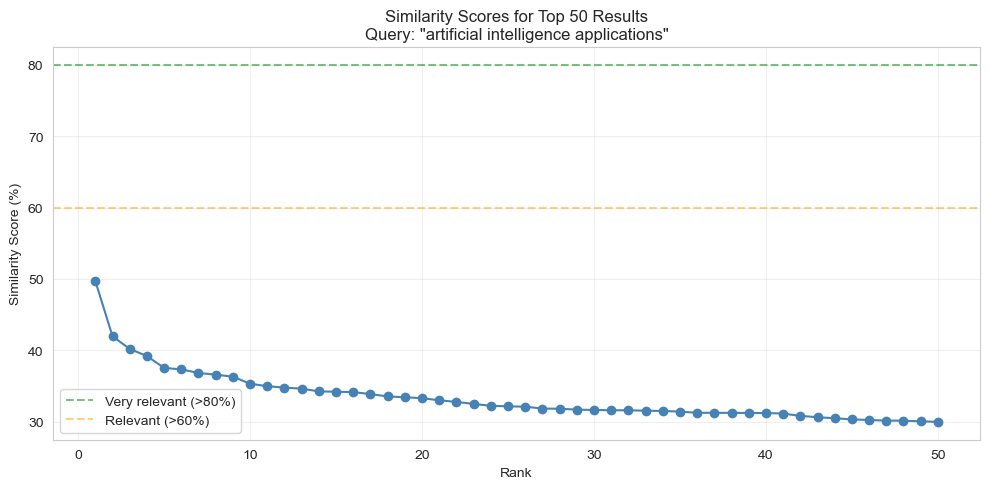

Top result similarity: 49.7%
50th result similarity: 30.0%


In [ ]:
# Search and check similarity distribution
query = "artificial intelligence applications"
query_emb = model.encode(query)

results = collection.query(
    query_embeddings=[query_emb.tolist()],
    n_results=50
)

distances = results['distances'][0]
similarities = [(2.0 - d) / 2.0 * 100 for d in distances]

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), similarities, marker='o', color='steelblue')
plt.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Very relevant (>80%)')
plt.axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Relevant (>60%)')
plt.title(f'Similarity Scores for Top 50 Results\nQuery: "{query}"')
plt.xlabel('Rank')
plt.ylabel('Similarity Score (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Top result similarity: {similarities[0]:.1f}%")
print(f"50th result similarity: {similarities[-1]:.1f}%")

## Summary - AI Models Used

### ✅ Segment 1: Text Embeddings
- **Model**: sentence-transformers (all-MiniLM-L6-v2)
- **Type**: Transformer-based embedding model
- **Purpose**: Convert text to 384-dim vectors
- **Performance**: ~2-5 min for 18K papers
- **Output**: Saved to `data/embeddings/paper_embeddings.npy`

### ✅ Segment 2: Vector Search
- **Model**: ChromaDB with HNSW algorithm
- **Type**: Approximate nearest neighbor search
- **Purpose**: Fast similarity search (clustering)
- **Performance**: <100ms per query
- **Output**: Vector database at `data/vector_db/`

---

